# Final project submitted by Daniel Chan, Feb 4, 2018

### Check software versions

In [1]:
import numpy as np
import pandas as pd 
import sklearn
import scipy.sparse 
import lightgbm 

for p in [np, pd, scipy, sklearn, lightgbm]:
    print (p.__name__, p.__version__)

numpy 1.13.3
pandas 0.20.3
scipy 0.19.1
sklearn 0.19.1
lightgbm 2.0.6


### setup the environment

In [2]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
%matplotlib inline 

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


from tqdm import tqdm_notebook

from itertools import product


def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

### Load data files

In [3]:
sales = pd.read_csv('../Final Project/sales_train.csv.gz')
shops = pd.read_csv('../Final Project/shops.csv')
items = pd.read_csv('../Final Project/items.csv')
item_cats = pd.read_csv('../Final Project/item_categories.csv')
ww = pd.read_csv('../Final Project/test.csv.gz')

### Concatenate `test` file to the end of `sales` dataframe so we can calculate meta-features consistently

In [4]:
#print (sales.head(5))
print (ww.head(5))
del sales['date'] 
del sales['item_price']
del ww['ID']
ww['item_cnt_day'] = 0
ww['date_block_num'] = 34

sales = pd.concat([sales,ww],ignore_index=True)


   ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268


# Get a feature matrix

### add up the number of items sold for each month.  Use data statistics max, min and standard deviation as advanced features.

In [5]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# additional features derived from sales statistics: max, min and std 

# Same as above but with shop-item-month max
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target_max':np.max}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-item-month min
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target_min':np.min}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-item-month mean
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target_mean':np.std}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

/home/danielchan/anaconda3/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


### Add Expanding Mean Encoding for items

In [6]:
globalmean = all_data['target'].mean()

csum   = all_data.groupby('item_id')['target'].cumsum() - all_data['target']
cumcnt = all_data.groupby('item_id').cumcount()

small = 0.

all_data['Expanding Mean'] = csum/(cumcnt+small)
all_data['Expanding Mean'].fillna(globalmean, inplace=True)    # Fill NaNs with global mean

encoded_feature = all_data['Expanding Mean'].values


corr = np.corrcoef(all_data['target'].values, encoded_feature)[0][1]
print(corr)

0.499605291823


In [7]:
print (all_data.shape)

(11128050, 10)


After creating a grid, we can calculate some features. We will use lags from [1, 2, 3, 4, 5, 12] months ago.

In [8]:
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols)) 

shift_range = [1, 2, 3, 4, 5, 12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

# Category for each item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
gc.collect();

A Jupyter Widget

Take a look at the `all_data` variable

In [9]:
all_data.head(5)

,shop_id,item_id,date_block_num,target,target_max,target_min,target_mean,target_shop,target_item,Expanding Mean,Expanding Mean_lag_1,target_lag_1,target_item_lag_1,target_max_lag_1,target_mean_lag_1,target_min_lag_1,target_shop_lag_1,Expanding Mean_lag_2,target_lag_2,target_item_lag_2,target_max_lag_2,target_mean_lag_2,target_min_lag_2,target_shop_lag_2,Expanding Mean_lag_3,...,target_mean_lag_3,target_min_lag_3,target_shop_lag_3,Expanding Mean_lag_4,target_lag_4,target_item_lag_4,target_max_lag_4,target_mean_lag_4,target_min_lag_4,target_shop_lag_4,Expanding Mean_lag_5,target_lag_5,target_item_lag_5,target_max_lag_5,target_mean_lag_5,target_min_lag_5,target_shop_lag_5,Expanding Mean_lag_12,target_lag_12,target_item_lag_12,target_max_lag_12,target_mean_lag_12,target_min_lag_12,target_shop_lag_12,item_category_id
0,54,10297,12,4.0,1.0,1.0,0.000000,8198.0,23.0,0.483516,0.408451,3.0,42.0,1.0,0.000000,1.0,10055.0,0.064516,0.0,2.0,0.0,0.000000,0.0,7978.0,0.000000,...,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
1,54,10296,12,3.0,1.0,1.0,0.000000,8198.0,17.0,0.521739,0.615385,0.0,24.0,0.0,0.000000,0.0,10055.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38
2,54,10298,12,14.0,3.0,1.0,0.881917,8198.0,182.0,13.299270,14.136752,21.0,369.0,3.0,0.759555,1.0,10055.0,11.935065,119.0,1309.0,15.0,4.582378,1.0,7978.0,3.166667,...,2.12132,2.0,6676.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
3,54,10300,12,3.0,1.0,1.0,0.000000,8198.0,26.0,3.416058,3.829060,1.0,54.0,1.0,0.000000,1.0,10055.0,3.727273,31.0,361.0,5.0,1.423893,1.0,7978.0,0.944444,...,0.00000,0.0,6676.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
4,54,10284,12,1.0,1.0,1.0,0.000000,8198.0,3.0,0.133772,0.135321,0.0,4.0,0.0,0.000000,0.0,10055.0,0.138889,0.0,3.0,0.0,0.000000,0.0,7978.0,0.151335,...,0.00000,0.0,6676.0,0.166065,0.0,3.0,0.0,0.0,0.0,7827.0,0.160173,0.0,10.0,0.0,0.0,0.0,7792.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57


# Train/test split

### Split the data into train and test. We will treat last month data as the test set. `Test` should really be called `validation`

In [10]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
dates = all_data['date_block_num']

sub_block = dates.max()
last_block = dates.max() - 1
print('Test `date_block_num` is %d' % last_block)
print('Submit `date_block_num` is %d' % sub_block)

Test `date_block_num` is 33
Submit `date_block_num` is 34


In [11]:
dates_train = dates[dates <  last_block]
dates_test  = dates[dates == last_block]

X_train = all_data.loc[dates <  last_block].drop(to_drop_cols, axis=1)
X_test =  all_data.loc[dates == last_block].drop(to_drop_cols, axis=1)
X_sub  =  all_data.loc[dates == sub_block].drop(to_drop_cols, axis=1)


y_train = all_data.loc[dates <  last_block, 'target'].values
y_test =  all_data.loc[dates == last_block, 'target'].values

In [12]:
print (X_train.shape)

print (X_test.shape)

print (X_sub.shape)

(6186922, 45)
(238172, 45)
(214200, 45)


# First level models 

### Test meta-features

### Look at 3 different linear regressors

In [13]:
# Linear Regression

lr = LinearRegression()
lr.fit(X_train.values, y_train)
pred_lr = lr.predict(X_test.values)

pred_lr = pred_lr.clip(0,20.)
y_test = y_test.clip(0,20.)

print('Test RMSE for linreg is %f' % mean_squared_error(y_test, pred_lr))

Test RMSE for linreg is 0.963864


In [14]:
# Lasso Regression
from sklearn.linear_model import Lasso

lassoReg = Lasso(alpha=0.8)
lassoReg.fit(X_train.values, y_train) 
pred_lasso = lassoReg.predict(X_test.values)

pred_lasso = pred_lasso.clip(0,20.)
y_test = y_test.clip(0,20.)

print('Test RMSE for lassoReg is %f' % mean_squared_error(y_test, pred_lasso))

Test RMSE for lassoReg is 0.991678


In [15]:
from sklearn.linear_model import Ridge

ridgeReg = Ridge(alpha=0.5,normalize=True )

print (ridgeReg)
ridgeReg.fit(X_train.values, y_train) 
pred_ridge = ridgeReg.predict(X_test.values)

pred_ridge = pred_ridge.clip(0,20.)
y_test = y_test.clip(0,20.)

print('Test RMSE for ridgeReg is %f' % mean_squared_error(y_test, pred_ridge))

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)
Test RMSE for ridgeReg is 0.971632


### Tune the hyperparameters for LGB

In [16]:
ffs_to_try = np.linspace(0.4, 0.7, 10)

for ff in ffs_to_try:

    print('feature_fraction is %f' % ff)


    lgb_params = {
               'feature_fraction': ff,
               'metric': 'rmse',
               'nthread':8, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.01, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

    model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
    pred_lgb = model.predict(X_test)

    pred_lgb = pred_lgb.clip(0,20.)
    y_test = y_test.clip(0,20.)
    print('Test RMSE for LightGBM is %f' % mean_squared_error(y_test, pred_lgb))

feature_fraction is 0.400000
Test RMSE for LightGBM is 0.935499
feature_fraction is 0.433333
Test RMSE for LightGBM is 0.934284
feature_fraction is 0.466667
Test RMSE for LightGBM is 0.906183
feature_fraction is 0.500000
Test RMSE for LightGBM is 0.904924
feature_fraction is 0.533333
Test RMSE for LightGBM is 0.914229
feature_fraction is 0.566667
Test RMSE for LightGBM is 0.934948
feature_fraction is 0.600000
Test RMSE for LightGBM is 0.950086
feature_fraction is 0.633333
Test RMSE for LightGBM is 0.961090
feature_fraction is 0.666667
Test RMSE for LightGBM is 0.979925
feature_fraction is 0.700000
Test RMSE for LightGBM is 0.999587


In [18]:
lgb_params = {
               'feature_fraction': 0.5,
               'metric': 'rmse',
               'nthread':8, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.01, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
pred_lgb = model.predict(X_test)

pred_lgb = pred_lgb.clip(0,20.)
y_test = y_test.clip(0,20.)
print('Test RMSE for LightGBM is %f' % mean_squared_error(y_test, pred_lgb))

Test RMSE for LightGBM is 0.904924


Finally, concatenate test predictions to get test meta-features.

In [19]:
X_test_level2 = np.c_[pred_lr, pred_lgb] 


print (X_test_level2.shape)

(238172, 2)


### Meta-Features for the submission file

In [20]:
print (X_sub.shape)

sub_lr = lr.predict(X_sub.values).clip(0,20.)
#sub_lr = lassoReg.predict(X_sub.values).clip(0,20.)
sub_lgb = model.predict(X_sub).clip(0,20.)

X_sub_level2 = np.c_[sub_lr, sub_lgb] 
print (X_sub_level2.shape)

(214200, 45)
(214200, 2)


### Train meta-features

Implement ***scheme f)*** from the reading material. Here, we will use duration **T** equal to month and **M=15**.  

We need to get predictions (meta-features) from *linear regression* and *LightGBM* for months 27, 28, 29, 30, 31, 32. Use the same parameters as in above models.

In [21]:
dates_train_level2 = dates_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin([27, 28, 29, 30, 31, 32])]
y_train_level2 = y_train_level2.clip(0,20.)

In [22]:
# And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])


# Now fill `X_train_level2` with metafeatures
for cur_block_num in [27, 28, 29, 30, 31, 32]:
    
    print(cur_block_num)
    
    Xtemp = X_train[dates_train < cur_block_num]
    ytemp = y_train[dates_train < cur_block_num]
    
    Xtemp_1 = X_train[dates_train == cur_block_num]
    
    lr.fit(Xtemp.values, ytemp)
    pred_lr = lr.predict(Xtemp_1.values)
    pred_lr = pred_lr.clip(0,20.)
    
    model = lgb.train(lgb_params, lgb.Dataset(Xtemp, label=ytemp), 100)
    pred_lgb = model.predict(Xtemp_1)
    pred_lgb = pred_lgb.clip(0,20.)


    #X_train_level2[dates_train_level2==cur_block_num,:2] = np.c_[pred_lr, pred_lgb]
    X_train_level2[dates_train_level2==cur_block_num,:] = np.c_[pred_lr, pred_lgb]

#print (X_train_level2.shape)
#print(X_train_level2.mean(axis=0))    

27
28
29
30
31
32


### Make sure there is sufficient diversity between the 2 meta models

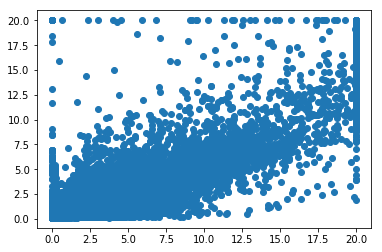

In [25]:
import matplotlib.pyplot as plt

plt.scatter(X_train_level2[:,0], X_train_level2[:,1])
plt.show()


# Ensembling

Now, when the meta-features are created, we can ensemble our first level models.

### Simple convex mix

Let's start with simple linear convex mix:

$$
mix= \alpha\cdot\text{linreg_prediction}+(1-\alpha)\cdot\text{lgb_prediction}
$$

We need to find an optimal $\alpha$ vy doing a grid search. Find the optimal $\alpha$ out of `alphas_to_try` array. 

### Determine the training error for simple convex mix

In [26]:
alphas_to_try = np.linspace(0, 1, 1001)

r2_train_simple_mix = 2.0

for alpha in alphas_to_try:
    mix = alpha*X_train_level2[:,0] + (1.0-alpha)*X_train_level2[:,1]   
    mix = mix.clip(0,20.)
    #print (np.amax(y_train_level2 - mix))

    rtemp = mean_squared_error(y_train_level2, mix)
    if (rtemp < r2_train_simple_mix) :
        r2_train_simple_mix = rtemp
        best_alpha = alpha
        

print('Best alpha: %f; Corresponding RMSE score on train: %f' % (best_alpha, r2_train_simple_mix))

Best alpha: 0.315000; Corresponding RMSE score on train: 0.726261


### Determine the testing (validation) error for simple convex mix

Now use the best $\alpha$ to compute predictions for the test set 

In [27]:
test_preds = best_alpha*X_test_level2[:,0]  +  (1.0-best_alpha)*X_test_level2[:,1]

test_preds = test_preds.clip(0,20.)
y_test = y_test.clip(0,20.)

print (X_test_level2.shape)
print (y_test.shape)
print (test_preds.shape)

r2_test_simple_mix = mean_squared_error(y_test, test_preds)     # YOUR CODE GOES HERE

print('Test RMSE for simple mix is %f' % r2_test_simple_mix)

(238172, 2)
(238172,)
(238172,)
Test RMSE for simple mix is 0.884330


# Stacking Method

Fit a linear regression model to the meta-features. Use the same parameters as in the model above.

In [28]:

linReg = LinearRegression(normalize=False)
linReg.fit(X_train_level2, y_train_level2)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Compute RSME on the train and test sets.

In [29]:
train_preds = linReg.predict(X_train_level2)  
train_preds = train_preds.clip(0,20.)                                       
r2_train_stacking = mean_squared_error(y_train_level2, train_preds)     

test_preds = linReg.predict(X_test_level2)              
test_preds = test_preds.clip(0,20.)                                     

r2_test_stacking = mean_squared_error(y_test, test_preds)   

print('Train RMSE for stacking is %f' % r2_train_stacking)
print('Test  RMSE for stacking is %f' % r2_test_stacking)



Train RMSE for stacking is 0.715539
Test  RMSE for stacking is 0.877475


### Stacking method produced a lower Test RMSE than simple mix method

# Prepare the Submission File

In [30]:
# submission using the stacking method
sub_preds = linReg.predict(X_sub_level2)              
sub_preds = sub_preds.clip(0,20.)  


# submission using the simple mix method
#sub_preds = best_alpha*X_sub_level2[:,0]  +  (1.0-best_alpha)*X_sub_level2[:,1]
#sub_preds = sub_preds.clip(0,20.)


print (X_sub.shape)
print (sub_preds.shape)

X_sub['target'] = sub_preds

ww = pd.read_csv('../Final Project/test.csv.gz')


submit = pd.merge(ww,X_sub,how='left',on=['shop_id', 'item_id']).fillna(0)

print (ww.shape)
print (submit.shape)

#print (submit.head(10))
#print (submit[submit.date_block_num == 0.0].count())

submit.to_csv(path_or_buf='submit_max_min.std_Mean_Encoding_stacking.csv',columns=['ID','target'], header=['ID', 'item_cnt_month'], index=False)

(214200, 45)
(214200,)
(214200, 3)
(214200, 47)
